In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
import torchvision
from PIL import Image
import IPython.display

In [2]:
imagesFilepath = "flickr\Flickr_Data\Images"
number_of_latent_variables = 2048

In [3]:
# Create a list of jpg image filepaths
found_jpg_filepaths = []
directory_contents = os.listdir(imagesFilepath)
for content in directory_contents:
    filepath = os.path.join(imagesFilepath, content)
    if filepath.endswith('.jpg'):
        found_jpg_filepaths.append(filepath)
print(found_jpg_filepaths[0])

flickr\Flickr_Data\Images\1000268201_693b08cb0e.jpg


In [4]:
training_images_filepath = "flickr\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt"
validation_images_filepath = "flickr\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt"
pretokenized_descriptions_filepath = "tokenized_descriptions_flickr.csv"
vocabulary_filepath = 'vocabulary_flickr.csv'
words2vec_dictionary_filepath = 'words2vec/flickr_words2vec.csv'
latent_representation_filepath = 'flickr_latent_resNet.csv'

latent_representationDf = pd.read_csv(latent_representation_filepath)
tokenized_descriptionsDf = pd.read_csv(pretokenized_descriptions_filepath)

In [5]:
with open(training_images_filepath, 'r') as train_images_file:
    train_images_list = [line.strip() for line in train_images_file]

In [6]:
def LoadVocabulary(vocabularyFilepath):
    word_to_index_dict = {}
    index_to_word_dict = {}
    vocabDf = pd.read_csv(vocabularyFilepath)
    for i, row in vocabDf.iterrows():
        index = row['index']
        word = row['word']
        word_to_index_dict[word] = index
        index_to_word_dict[index] = word
    return word_to_index_dict, index_to_word_dict

word_to_index_dict, index_to_word_dict = LoadVocabulary(vocabulary_filepath)

In [7]:
word2vecDf = pd.read_csv(words2vec_dictionary_filepath)
embedding_dimension = 128
word_to_embedding_dict = {word2vecDf.iloc[i]['word'] : word2vecDf.loc[i, 'e0': 'e{}'.format(embedding_dimension - 1)].tolist()
                              for i in range(len(word2vecDf))}

In [8]:
t1 = torch.tensor(word_to_embedding_dict['boys'])
t2 = torch.tensor(word_to_embedding_dict['girl'])
t3 = t2 = torch.tensor(word_to_embedding_dict['woman'])

cos_sim1 = torch.nn.functional.cosine_similarity(t1, t2, dim=0)
cos_sim2 = torch.nn.functional.cosine_similarity(t2, t3, dim=0)

print(cos_sim1)
print(cos_sim2)

tensor(-0.0475, dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [9]:
import en_core_web_sm
import re
import string

nlp = en_core_web_sm.load()

def Tokenize(text, nlp):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')  # Remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    tokens = [token.text for token in nlp.tokenizer(nopunct) if not token.text.isspace()]
    return tokens

In [10]:
from torch.utils.data import Dataset, DataLoader
import random

class CaptionGenerationDataset(Dataset):
    def __init__(self,
                 image_filenames,
                 image_filename_to_latent_variables,
                 image_filename_to_tokenized_descriptions_list,
                 endOfSeqIndex,
                 notSetIndex,
                 vocabulary_size,
                 index_to_word_dict,
                 word_to_embedding_dict
                 ):
        self.image_filenames = image_filenames
        self.image_filename_to_latent_variables = image_filename_to_latent_variables
        self.image_filename_to_tokenized_descriptions_list = image_filename_to_tokenized_descriptions_list
        self.endOfSeqIndex = endOfSeqIndex
        self.notSetIndex = notSetIndex
        self.vocabulary_size = vocabulary_size
        self.index_to_word_dict = index_to_word_dict
        self.word_to_embedding_dict = word_to_embedding_dict

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if idx >= len(self.image_filenames):
            raise IndexError("CaptionGenerationDataset.__getitem__(): Index {} is greater than the number of images ({})".format(idx, len(self.image_filenames)))
        filename = self.image_filenames[idx]
        latent_variables = self.image_filename_to_latent_variables[filename]
        # Build a tensor
        latent_variablesTsr = torch.zeros(len(latent_variables))
        for i in range(len(latent_variables)):
            latent_variablesTsr[i] = latent_variables[i]
        # Randomly choose one of the descriptions
        description = random.choice(self.image_filename_to_tokenized_descriptions_list[filename])
        lastIndex = self.IndexOfEndOfSeq(description)
        chopIndex = random.randint(0, lastIndex) - 1 # The last index of the chopped description
        choppedDescription = [self.notSetIndex] * len(description)
        if chopIndex >= 0:
            for i in range(chopIndex + 1):
                choppedDescription[i] = description[i]

        embedding_dim = len(self.word_to_embedding_dict[ self.index_to_word_dict[0] ]) # Length of the embedding of the 1st word
        embeddedChoppedDescriptionTsr = torch.zeros((len(description), embedding_dim))
        for wordPosn in range(len(choppedDescription)):
            embedding = self.word_to_embedding_dict[ self.index_to_word_dict[choppedDescription[wordPosn]]]
            embeddedChoppedDescriptionTsr[wordPosn] = torch.tensor(embedding)

        next_word_index = description[chopIndex + 1]

        return ( (latent_variablesTsr, embeddedChoppedDescriptionTsr), next_word_index)

    def IndexOfEndOfSeq(self, description_list):
        foundIndex = -1
        for candidateNdx in range(len(description_list)):
            if description_list[candidateNdx] == self.endOfSeqIndex:
                foundIndex = candidateNdx
                break
        if foundIndex == -1:
            return len(description_list) - 1
        else:
            return foundIndex
        
def ImageFilenameToLatentVariables(latent_varDf):
    image_filename_to_latent_variables = {}
    for i, row in latent_varDf.iterrows():
        filepath = latent_varDf.iloc[i][0]
        filename = os.path.basename(filepath)
        latent_variables = list(latent_varDf.iloc[i][1:])
        image_filename_to_latent_variables[filename] = latent_variables
    return image_filename_to_latent_variables

image_filename_to_latent_variables = ImageFilenameToLatentVariables(latent_representationDf)

def ImageFilenameToTokenizedDescriptionsList(descriptionsDF):
    image_filename_to_tokenized_description = {}
    for i, row in descriptionsDF.iterrows():
        filename = descriptionsDF.iloc[i][0]
        tokenized_description = list(descriptionsDF.iloc[i][1:])
        if filename in image_filename_to_tokenized_description:
            image_filename_to_tokenized_description[filename].append(tokenized_description)
        else:
            image_filename_to_tokenized_description[filename] = [tokenized_description]
    return image_filename_to_tokenized_description

image_filename_to_tokenized_descriptions_list = ImageFilenameToTokenizedDescriptionsList(tokenized_descriptionsDf)

lstm_train_dataset = CaptionGenerationDataset(
        train_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )

In [11]:
with open(validation_images_filepath, 'r') as valid_images_file:
    validation_images_list = [line.strip() for line in valid_images_file]
lstm_validation_dataset = CaptionGenerationDataset(
        validation_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )

In [12]:
useCuda = torch.cuda.is_available()
class BiLSTM_fixed_embedding(torch.nn.Module):
    def __init__(self, embedding_dim, lstm_hidden_dim,
                 num_lstm_layers, image_latent_dim,
                 vocab_size,
                 dropoutProportion=0.65):
        super(BiLSTM_fixed_embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_dim, num_lstm_layers, batch_first=True, bidirectional=True)  # Bidirectional LSTM
        self.dropout = torch.nn.Dropout(dropoutProportion)
        self.linear = torch.nn.Linear(lstm_hidden_dim * 2 + image_latent_dim, vocab_size)  # Adjusting linear layer input size for bidirectional LSTM


    def forward(self, image_latentTsr, embeddedChoppedDescriptionTsr):
        aggregated_h, (ht, ct) = self.lstm(embeddedChoppedDescriptionTsr)
        # Concatenating the final hidden states from both directions
        concat_latent = torch.cat((torch.nn.functional.normalize(ht[-2,:,:]), torch.nn.functional.normalize(ht[-1,:,:]), torch.nn.functional.normalize(image_latentTsr)), dim=1)  # Using ht[-2,:,:] and ht[-1,:,:] for bidirectional LSTM
        outputTsr = self.linear(self.dropout(concat_latent))
        return outputTsr
    
    
    def Caption(self, latentVariablesTsr, maximumLength, word_to_embedding_dict, index_to_word_dict, endOfSeqIndex, useCuda):
        notSetEmbedding = word_to_embedding_dict['NOTSET']
        embeddedChoppedDescriptionTsr = torch.zeros((maximumLength, self.embedding_dim))
        for i in range(maximumLength):
            embeddedChoppedDescriptionTsr[i] = torch.tensor(notSetEmbedding)
        endOfSeqIsFound = False
        runningNdx = 0
        caption_words = []
        while not endOfSeqIsFound and runningNdx < maximumLength:
            if useCuda:
                latentVariablesTsr = latentVariablesTsr.cuda()
                embeddedChoppedDescriptionTsr = embeddedChoppedDescriptionTsr.cuda()
            outputTsr = self.forward(latentVariablesTsr.unsqueeze(0), embeddedChoppedDescriptionTsr.unsqueeze(0))
            next_word_index = torch.argmax(outputTsr[0]).item()
            caption_words.append(index_to_word_dict[next_word_index])
            next_word = index_to_word_dict[next_word_index]
            embeddedChoppedDescriptionTsr[runningNdx] = torch.tensor(word_to_embedding_dict[next_word])
            runningNdx += 1
            if next_word_index == endOfSeqIndex:
                endOfSeqIsFound = True
        return caption_words

lstm_hidden_dimension = 64
lstm_number_of_layers = 3
dropoutProportion = 0.6
lstm_model =  BiLSTM_fixed_embedding(
        embedding_dim=embedding_dimension,
        lstm_hidden_dim=lstm_hidden_dimension,
        num_lstm_layers=lstm_number_of_layers,
        image_latent_dim=number_of_latent_variables,
        vocab_size=len(word_to_index_dict),
        dropoutProportion=dropoutProportion
    )

if useCuda:
    lstm_model = lstm_model.cuda()

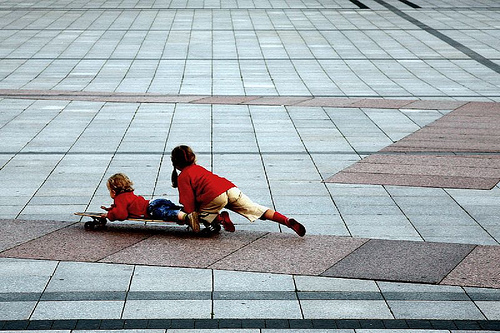

In [13]:
def TestSample(index, validation_images_list, image_filename_to_latent_variables, model,
               index_to_word_dict,
               word_to_embedding_dict,
               sequence_length=40,
               endOfSeqIndex=0,
               useCuda=True):
    sample_filename = validation_images_list[index]
    sample_latentVariablesTsr = torch.FloatTensor(image_filename_to_latent_variables[sample_filename])
    if useCuda:
        sample_latentVariablesTsr = sample_latentVariablesTsr.cuda()
    sample_words = model.Caption(
        latentVariablesTsr=sample_latentVariablesTsr,
        maximumLength=sequence_length,
        word_to_embedding_dict=word_to_embedding_dict,
        index_to_word_dict=index_to_word_dict,
        endOfSeqIndex=endOfSeqIndex,
        useCuda=useCuda
    )
    return sample_words

validation_sample_0_Ndx = 0
validation_sample_100_Ndx = 100
IPython.display.Image(os.path.join(imagesFilepath, validation_images_list[validation_sample_0_Ndx]))

In [14]:
best_model_filepath = 'bilstm_rNet_flickr.pth'

In [30]:
import sys

parameters = filter(lambda p: p.requires_grad, lstm_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0003)
lossFcn = torch.nn.CrossEntropyLoss()
train_dataLoader = DataLoader(lstm_train_dataset, batch_size=16, shuffle=True)
validation_dataLoader = DataLoader(lstm_validation_dataset, batch_size=lstm_validation_dataset.__len__())

lowestValidationLoss = 3.0483999252319336
# lowestValidationLoss at dropout = 0.6 is 3.0483999252319336

for epoch in range(1, 500 + 1):
    lstm_model.train()
    loss_sum = 0.0
    numberOfBatches = 0
    for ( (latent_variablesTsr, chopped_descriptionTsr), target_next_word) in train_dataLoader:
        if numberOfBatches % 4 == 1:
            print (".", end="", flush=True)
        if useCuda:
            latent_variablesTsr = latent_variablesTsr.cuda()
            chopped_descriptionTsr = chopped_descriptionTsr.cuda()
            target_next_word = target_next_word.cuda()
        predicted_next_word = lstm_model(latent_variablesTsr, chopped_descriptionTsr)
#         print(predicted_next_word)
        optimizer.zero_grad()
        loss = lossFcn(predicted_next_word, target_next_word)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        numberOfBatches += 1
    train_loss = loss_sum/numberOfBatches
    print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))

    # Validation
    lstm_model.eval()
    sample_0_words = TestSample(validation_sample_0_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_0_words = {}".format(sample_0_words))
    sample_100_words = TestSample(validation_sample_100_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_100_words = {}".format(sample_100_words))
    
    for ((validation_latent_variablesTsr, validation_chopped_descriptionTsr), validation_target_next_word) in validation_dataLoader:
        if useCuda:
            validation_latent_variablesTsr = validation_latent_variablesTsr.cuda()
            validation_chopped_descriptionTsr = validation_chopped_descriptionTsr.cuda()
            validation_target_next_word = validation_target_next_word.cuda()
        validation_predicted_next_word = lstm_model(validation_latent_variablesTsr, validation_chopped_descriptionTsr)
        validation_loss = lossFcn(validation_predicted_next_word, validation_target_next_word).item()
    print ("validation_loss = {}".format(validation_loss))

    if validation_loss < lowestValidationLoss:
        lowestValidationLoss = validation_loss
        torch.save(lstm_model.state_dict(), best_model_filepath)

.

KeyboardInterrupt: 

In [15]:
test_images_filepath = 'flickr/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
with open(test_images_filepath, 'r') as test_images_file:
    test_images_list = [line.strip() for line in test_images_file]
    
print("lowest validation loss = {}".format(lowestValidationLoss))
print ("len(test_images_list) = {}".format(len(test_images_list)))

len(test_images_list) = 1000


In [16]:
# Load the model that gave the lowest validation loss
lstm_model.load_state_dict(torch.load(best_model_filepath))
# Randomly select some test images
test_image_sample_indices = random.choices(range(len(test_images_list)), k=3)
lstm_model.eval()
test_sample_filepaths = []
test_sample_captions = []
for test_image_sample_index in test_image_sample_indices:
    sample_words = TestSample(test_image_sample_index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    caption = ' '.join(sample_words)
    test_sample_filepaths.append(os.path.join(imagesFilepath, test_images_list[test_image_sample_index]))
    test_sample_captions.append(caption)

a dog running in the water ENDOFSEQ


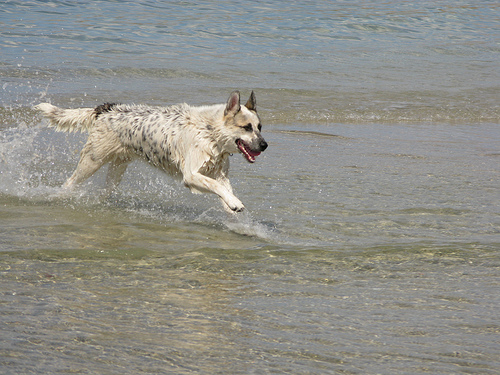

In [20]:
print (test_sample_captions[0])
IPython.display.Image(test_sample_filepaths[0])

In [21]:
import nltk
import csv
from nltk.translate.bleu_score import sentence_bleu
from collections import defaultdict


# Load tokenized descriptions
tokenized_descriptions = defaultdict(list)
with open(pretokenized_descriptions_filepath, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        image_name = row[0]
        caption_indices = []
        for index_str in row[1:]:
            index = int(index_str)
            if index == 2:
                break  # Stop capturing indices when index is 2
            caption_indices.append(index)
        tokenized_descriptions[image_name].append(caption_indices)

In [22]:
print(tokenized_descriptions['97731718_eb7ba71fd3.jpg'])

[[3, 502, 1, 13, 62, 176, 795, 57, 410, 4, 5, 717, 0], [3, 207, 1777, 1250, 32, 33, 3, 1, 0], [15, 8, 14, 410, 1468, 3, 502, 10, 23, 33, 5, 717, 0], [23, 1403, 3, 207, 3324, 247, 1250, 4, 5, 717, 0], [5, 410, 915, 5, 1250, 51, 23, 8, 3, 9, 33, 5, 717, 0]]


In [24]:
# Function to convert indices to words
def indices_to_words(indices):
    return [index_to_word_dict[index] for index in indices]

# Calculate BLEU score for each test image
total_bleu_score_1 = 0
total_bleu_score_2 = 0
total_bleu_score_3 = 0
total_bleu_score_4 = 0
total_images = len(test_images_list)
lstm_model.eval()
test_image_sample_indices_all = len(test_images_list);

for index in  range(test_image_sample_indices_all):
     sample_words = TestSample(index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
     description = ' '.join(sample_words)
     candidate_caption = Tokenize(description, nlp)

     reference_captions = [indices_to_words(indices) for indices in tokenized_descriptions[test_images_list[index]]]

     bleu_score_1 = sentence_bleu(reference_captions, candidate_caption, weights=(1, 0, 0, 0))
     bleu_score_2 = sentence_bleu(reference_captions, candidate_caption, weights=(0.5, 0.5, 0, 0))
     bleu_score_3 = sentence_bleu(reference_captions, candidate_caption, weights=(0.33, 0.33, 0.33, 0))
     bleu_score_4 = sentence_bleu(reference_captions, candidate_caption, weights=(0.25, 0.25, 0.25, 0.25))
    
     total_bleu_score_1 += bleu_score_1
     total_bleu_score_2 += bleu_score_2
     total_bleu_score_3 += bleu_score_3
     total_bleu_score_4 += bleu_score_4

average_bleu_score_1 = total_bleu_score_1 / total_images
average_bleu_score_2 = total_bleu_score_2 / total_images
average_bleu_score_3 = total_bleu_score_3 / total_images
average_bleu_score_4 = total_bleu_score_4 / total_images

# average_bleu_score = total_bleu_score / len(test_images)
print("Average BLEU-1 score:", average_bleu_score_1)
print("Average BLEU-2 score:", average_bleu_score_2)
print("Average BLEU-3 score:", average_bleu_score_3)
print("Average BLEU-4 score:", average_bleu_score_4)


Average BLEU-1 score: 0.5178373924083693
Average BLEU-2 score: 0.33272679312348324
Average BLEU-3 score: 0.1512418496103794
Average BLEU-4 score: 0.05477884247557497
